# Principle Component Analysis
Say we have N of D dimensional data points so our dataset will be $X \in R^{D \times N}$ with covariance $\Sigma \in R^{D \times D}$. We want the best ideas to reduce dimensionality of our dataset so that in the end we have $X' \in R^{q \times N}$ where $q << D$.

One idea is to project all the points into a direction which retains the most variance in our dataset, and that was the original idea of **PCA**.

If you feel comfortable with the covariance matrix and the related transformation it can apply to the data you can continue on. But if you want to get an image of the idea take a look [here](http://www.visiondummy.com/2014/04/geometric-interpretation-covariance-matrix/).

In 2D space we know that any data can be made by transformation of the white data (drawn from 2D normal RV with mean zero and diagonal covariance matrix with diagonal elements or variances equal 1). This transformation includes a scaling **S** and a rotation **R**. So transformation $T = RS$. If the covariance of the white data is $\Sigma = \begin{bmatrix} 1 & 0 \\ 0 & 1 \\ \end{bmatrix}$ and $D' = TD$ then $\Sigma' = RSSR^{-1}$. On the other hand $\Sigma' = VLV^{-1}$ where L is the diagonal matrix with eigenvalues and each column of V includes the respective eigen vectors. After equating previous two relations eigenvectors V are seen as only rotations and eigenvalues L are the scale in that direction. If we wanted to capture just the highest amont of variance in our data then this unit vector will be the eigenvector corresponding to the largest eigenvalue of the covariance matrix of the original dataset. So if that direction can be shown by a vector $U \in R^{D \times 1}$ (q=1) then $ X' = U^TX$  and $ X' \in R^{1 \times N} $. This statement can be more formarly followed in *Strang Linear Algebra page 475; ISBN: 9780980232714*. To preserve more than 1 dimension we can either sequentially find the largest eigenvector and falt out data in that direction by subtracting it from each datapoint and continue this procedure upto the desired dimension or equally take the first largest eigenvalues and the corresponding eigenvectors and transform data in their direction.

Lets have an example:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.io import loadmat
from scipy.stats import multivariate_normal


from scipy.linalg import det
from scipy.linalg import pinv2 as inv #pinv uses linalg.lstsq algorithm while pinv2 uses SVD
from numpy.linalg import svd

%matplotlib inline
%load_ext autoreload
%autoreload 2
%autosave 0

Autosave disabled


We will work with [MNIST](http://yann.lecun.com/exdb/mnist/) handwritten digits dataset. We will work with zeros and ones. Dataset includes ~6K images of $28 \times 28 = 784$ pixels for each digit. Through out the note we will reduce the dimensionality to only 2 dimensions and we will try to classify zeros and ones in the visualizable 2D space and measure the performance based on highest accuracy achievable.

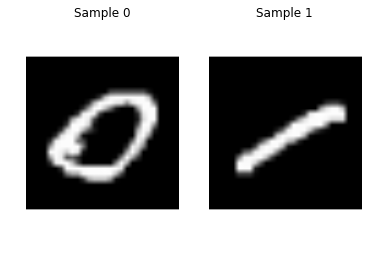

In [2]:
mnist_train = loadmat('mnist_train.mat')['train']
D0 = mnist_train[0,9]
D1 = mnist_train[0,0]

sample0 = D0[:,0].reshape((28,28))
sample1 = D1[:,0].reshape((28,28))
f, axarr = plt.subplots(1,2, sharex=True)
axarr[0].imshow(sample0,cmap='gray');axarr[0].set_title('Sample 0')
axarr[1].imshow(sample1,cmap='gray');axarr[1].set_title('Sample 1')
axarr[0].axis('off')
axarr[1].axis('off')
plt.show()

#### PCA code:

In [3]:
def computeCovariance(D):
    '''computing the covariance function'''
    # center data and compute the covariances
    N = D.shape[1];
    originalD = D.shape[0] #784 is the original dimension
    M = D.mean(axis = 1).reshape(originalD,1) #mean of all pixels in the dataset
    centered_D = D-M
    COV = (np.dot((D-M),(D-M).T.conj()))/(N-1)
    return COV
    
def PCA(D,newD=2):
    ''' newD: we want to show all data in 2D
        D_ld: low dimenstional data
        '''
    #COV = computeCovariance(D)
    COV = np.cov(D)
    U,S,V = svd(COV)

    D_ld = np.dot(U[:,0:newD].T,D)
    return U,D_ld

#### Visualization of the results

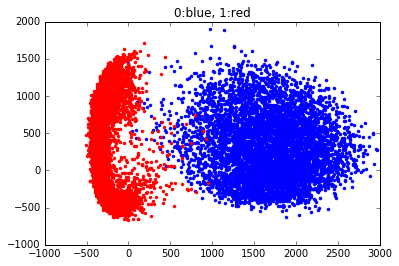

In [4]:
def visualize_lowD_01(D_ld,N0,N1):
    D0_ld = D_ld[:,0:N0]
    D1_ld = D_ld[:,N0+1:]
    f, ax = plt.subplots()

    ax.plot(D0_ld[0,:],D0_ld[1,:],'b.')
    ax.plot(D1_ld[0,:],D1_ld[1,:],'r.')
    ax.set_title('0:blue, 1:red')

    plt.show()
    

newD = 2 # project data into 2D

D = np.hstack([D0,D1])
N0 = D0.shape[1];N1 = D1.shape[1]
U, _ = PCA(D)
D_ld = np.dot(U[:,0:newD].T,D)

visualize_lowD_01(D_ld,N0,N1)

Two clusters of data points should be visible in the above plot.We check how easily we can classify using MAP estimator assuimg equally probable classes with bivarite normal distribution:

In [5]:
def MAP_01_classifier(X0,X1):
    '''If we have zeros of 1s and 0s how easy it can be to 
    detect them with equiprobable bivariate normals. The higher the better'''
    M0 = np.mean(X0,axis = 1)
    M1 = np.mean(X1,axis = 1)

    COV0 = np.cov(X0)
    COV1 = np.cov(X1)

    mvn0 = multivariate_normal(M0,COV0)
    mvn1 = multivariate_normal(M1,COV1)

    P00 =  mvn0.pdf(X0.T)
    P10 = mvn1.pdf(X0.T)
    sumP = P00+P10
    estim_zero = P00/sumP > P10/sumP
    

    P01 =  mvn0.pdf(X1.T)
    P11 = mvn1.pdf(X1.T)
    sumP = P01+P11
    estim_one = P01/sumP < P11/sumP
    
    acc0 =  sum(estim_zero)/float(N0)
    acc1 = sum(estim_one)/float(N1)
    
    return acc0,acc1

D0_ld = D_ld[:,0:N0]
D1_ld = D_ld[:,N0+1:]
MAP_01_classifier(D0_ld,D1_ld)

(0.99831166638527769, 0.98976564817561552)

We reconstruct the data from this low dimentional information and see how good the result might be:

In [6]:
def reconstruction_err(D,D_hat): return np.mean(np.sqrt(np.sum((D-D_hat)**2,axis=0)))/np.mean(np.sqrt(np.sum((D)**2,axis=0)))

D_hat = np.dot(U[:,0:2],D_ld)

print reconstruction_err(D,D_hat)

20.1627719454


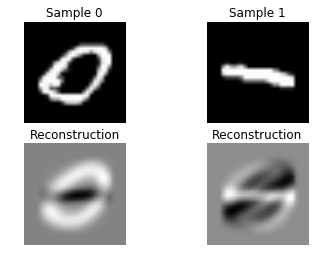

In [7]:
def visualize_reconstructed_01(D,D_hat,N0,N1):
    sample0 = D[:,0].reshape((28,28))
    sample1 = D[:,N0+1].reshape((28,28))
    sample0_hat = D_hat[:,0].reshape((28,28))
    sample1_hat = D_hat[:,N0+1].reshape((28,28))
    f, axarr = plt.subplots(2,2)
    axarr[0,0].imshow(sample0,cmap='gray');axarr[0,0].set_title('Sample 0')
    axarr[0,1].imshow(sample1,cmap='gray');axarr[0,1].set_title('Sample 1')
    axarr[1,0].imshow(sample0_hat,cmap='gray');axarr[1,0].set_title('Reconstruction')
    axarr[1,1].imshow(sample1_hat,cmap='gray');axarr[1,1].set_title('Reconstruction')

    axarr[0,0].axis('off')
    axarr[0,1].axis('off')
    axarr[1,0].axis('off')
    axarr[1,1].axis('off')
    plt.show()
    

visualize_reconstructed_01(D,D_hat,N0,N1)

## Gaussian Process Latent Variable Model
A probabilistic model used originaly for dimensionality reduction

In [8]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)


Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
